In [1]:
import datetime

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras import Input

from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

In [2]:
def get_yfinance_data(ticker, start_date=None, end_date=None, period=None, interval='1d'):
    """
    Fetch financial data from Yahoo Finance and return as pandas DataFrame.
    
    Parameters:
    - ticker (str): Stock ticker symbol (e.g., 'AAPL', 'MSFT')
    - start_date (str): Start date in YYYY-MM-DD format (optional)
    - end_date (str): End date in YYYY-MM-DD format (optional)
    - period (str): Time period (e.g., '1mo', '1y', 'max') (optional)
    - interval (str): Data interval ('1d', '1h', '1m', etc.)
    
    Returns:
    - pd.DataFrame: DataFrame containing the financial data
    """
    
    # Validate that either period or start/end dates are provided
    if period is None and (start_date is None or end_date is None):
        raise ValueError("Either provide a period or both start and end dates")
    
    # Download the data
    stock = yf.Ticker(ticker)
    
    if period:
        data = stock.history(period=period, interval=interval)
    else:
        data = stock.history(start=start_date, end=end_date, interval=interval)
    
    # Reset index to make Date a column
    data.reset_index(inplace=True)
    
    return data

In [3]:
start_date = datetime.datetime(2020, 1, 1)
end_date   = datetime.date.today()
# data       = get_yfinance_data('AAPL', start_date, end_date)
# data.to_csv("../Data File/AAPL_OHLC.csv")
data = pd.read_csv("../Data File/AAPL_OHLC.csv")

# preprocessing
# params:
look_back = 100 # days
train_to_test_ratio = 0.70

# data preprocessing
data.drop(columns=["Unnamed: 0", "Dividends", "Stock Splits", "Volume"], inplace=True)
train_idx = int(data.shape[0] * train_to_test_ratio)
test_len  = data.shape[0] - train_idx
x_train = np.zeros((train_idx-look_back, (data.shape[1] - 1)*0+1 * look_back))
y_train = np.zeros((train_idx-look_back, (data.shape[1] - 1)*0+1))
x_test = np.zeros((test_len-look_back,   (data.shape[1] - 1)*0+1 * look_back))
y_test = np.zeros((test_len-look_back,   (data.shape[1] - 1)*0+1))

for i in range(look_back, train_idx):
    x_train[i-look_back, :] = data.values[i - look_back:i, -1]
    y_train[i-look_back, :] = data.values[i, -1]
    
for i in range(train_idx+look_back, train_idx+test_len):
    x_test[i-(train_idx+look_back), :] = data.values[i - look_back:i, -1]
    y_test[i-(train_idx+look_back), :] = data.values[i, -1]

data_normalizer = MinMaxScaler(feature_range=(0,1))
data_normalizer.fit_transform(x_train)
scale = np.min(data_normalizer.scale_)
x_train_normalized = x_train * scale
y_train_normalized = y_train * scale
x_test_normalized = x_test * scale
y_test_normalized = y_test * scale

In [ ]:
model_1 = Sequential([
    Input((x_train[0].shape[0], 1)),
    LSTM(120 * y_train[0].shape[0], activation='relu', return_sequences=True),
    Dropout(0.2),
    LSTM(60 * y_train[0].shape[0], activation='relu', return_sequences=True),
    Dropout(0.3),
    LSTM(80 * y_train[0].shape[0], activation='relu', return_sequences=True),
    Dropout(0.4),
    LSTM(120 * y_train[0].shape[0], activation='relu'),
    Dropout(0.5),
    Dense(y_train[0].shape[0])
])

model_2 = Sequential([
    Input((x_train[0].shape[0], 1)),
    LSTM(120 * y_train[0].shape[0], activation='relu', return_sequences=True),
    Dropout(0.2),
    LSTM(60 * y_train[0].shape[0], activation='relu', return_sequences=True),
    Dropout(0.3),
    LSTM(80 * y_train[0].shape[0], activation='relu', return_sequences=True),
    LSTM(80 * y_train[0].shape[0], activation='relu', return_sequences=True),
    Dropout(0.4),
    LSTM(120 * y_train[0].shape[0], activation='relu'),
    Dropout(0.5),
    Dense(y_train[0].shape[0])
])

model_3 = Sequential([
    Input((x_train[0].shape[0], 1)),
    LSTM(120 * y_train[0].shape[0], activation='relu', return_sequences=True),
    Dropout(0.2),
    LSTM(60 * y_train[0].shape[0], activation='relu', return_sequences=True),
    LSTM(60 * y_train[0].shape[0], activation='relu', return_sequences=True),
    LSTM(60 * y_train[0].shape[0], activation='relu', return_sequences=True),
    Dropout(0.3),
    LSTM(80 * y_train[0].shape[0], activation='relu', return_sequences=True),
    Dropout(0.4),
    LSTM(120 * y_train[0].shape[0], activation='tanh'),
    Dropout(0.5),
    Dense(y_train[0].shape[0])
])

model_1.compile(optimizer='adam', loss='mean_absolute_error', metrics=['MAE'])
model_2.compile(optimizer='adam', loss='mean_absolute_error', metrics=['MAE'])
model_3.compile(optimizer='adam', loss='mean_absolute_error', metrics=['MAE'])

# model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100, 120)       │        58,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 120)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100, 60)        │        43,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100, 60)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 100, 80)        │        45,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100, 80)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 120)            │        96,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           121 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243,721 (952.04 KB)

 Trainable params: 243,721 (952.04 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
model_1.fit(x_train_normalized, y_train_normalized, batch_size=32, epochs=20, validation_data=(x_test_normalized, y_test_normalized))
model_2.fit(x_train_normalized, y_train_normalized, batch_size=32, epochs=20, validation_data=(x_test_normalized, y_test_normalized))
model_3.fit(x_train_normalized, y_train_normalized, batch_size=32, epochs=20, validation_data=(x_test_normalized, y_test_normalized))

Epoch 1/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - MAE: 0.6427 - loss: 0.6427 - val_MAE: 0.0725 - val_loss: 0.0725
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - MAE: 0.1748 - loss: 0.1748 - val_MAE: 0.2950 - val_loss: 0.2950
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - MAE: 0.1331 - loss: 0.1331 - val_MAE: 0.1957 - val_loss: 0.1957
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - MAE: 0.1346 - loss: 0.1346 - val_MAE: 0.2334 - val_loss: 0.2334
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - MAE: 0.1385 - loss: 0.1385 - val_MAE: 0.3278 - val_loss: 0.3278
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - MAE: 0.1501 - loss: 0.1501 - val_MAE: 0.1528 - val_loss: 0.1528
Epoch 7/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step - MAE: 0.1443 - loss: 0.1443 - val_MAE: 0.0951 - val_loss: 0.0951
Epoch 8/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - MAE: 0.1432 - loss: 0.1432 - val_MAE: 0.2160 - val_loss: 0.2160
Epoch 9/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - MA

In [6]:
model_1.evaluate(x_test_normalized, y_test_normalized)
model_2.evaluate(x_test_normalized, y_test_normalized)
model_3.evaluate(x_test_normalized, y_test_normalized)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - MAE: 0.1473 - loss: 0.1473
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - MAE: 0.2336 - loss: 0.2336
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - MAE: 0.0909 - loss: 0.0909


[0.12180116772651672, 0.12180116772651672]

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 159ms/step


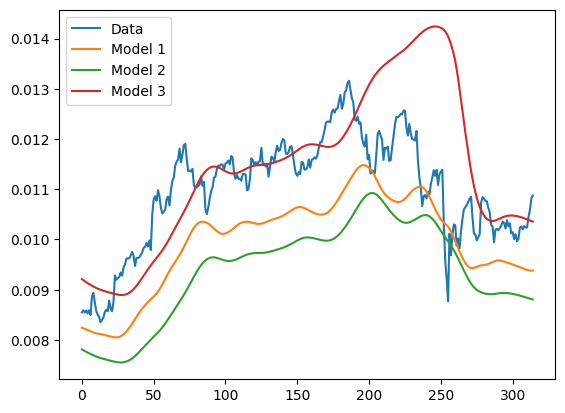

In [7]:
plt.plot(y_test_normalized * scale, label="Data")
plt.plot(model_1.predict(x_test_normalized) * scale, label="Model 1")
plt.plot(model_2.predict(x_test_normalized) * scale, label="Model 2")
plt.plot(model_3.predict(x_test_normalized) * scale, label="Model 3")
plt.legend()

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step


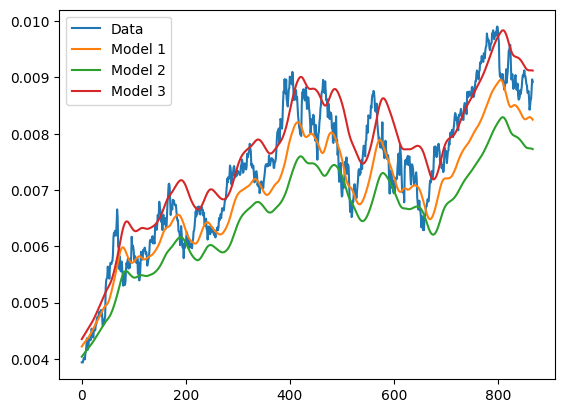

In [8]:
plt.plot(y_train_normalized * scale, label="Data")
plt.plot(model_1.predict(x_train_normalized) * scale, label="Model 1")
plt.plot(model_2.predict(x_train_normalized) * scale, label="Model 2")
plt.plot(model_3.predict(x_train_normalized) * scale, label="Model 3")
plt.legend()